In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
from glob import glob
from subprocess import check_call, CalledProcessError

import pandas as pd
import numpy as np
import yaml

import matplotlib.pyplot as plt

import cson_forge

ERROR 1: PROJ: proj_create_from_database: Open of /home/x-mlong/.local/share/mamba/envs/cson-forge-v0/share/proj failed



Query the blueprint catalog to find the run blueprint matching the specified model and grid. This provides the path to the simulation output directory.


Find all model output files matching the pattern. These files contain the time-series data for the variable of interest.

In [2]:
domains_file = "domains-bm-scaling.yml"

In [3]:
# Read domains file and extract domain keys
# Resolve domains file path (relative to notebook directory)
domains_path = Path(domains_file)
if not domains_path.is_absolute():
    domains_path = Path.cwd() / domains_path

# Load domains YAML file
with open(domains_path, 'r') as f:
    domains_data = yaml.safe_load(f) or {}

# Extract domain keys (main keys in the YAML file)
domain_keys = list(domains_data.keys())

print(f"Loaded {len(domain_keys)} domain(s) from {domains_path}")
print(f"Domain keys: {domain_keys}")

Loaded 5 domain(s) from /home/x-mlong/codes/cson-forge/workflows/computing-benchmarks/domains-bm-scaling.yml
Domain keys: ['ccs-12km_20procs', 'ccs-12km_70procs', 'ccs-12km_280procs', 'ccs-12km_352procs', 'ccs-12km_1232procs']



Load the model grid from the blueprint's grid YAML file. The grid provides coordinate information (lon_rho, lat_rho) and masking for proper visualization.

In [4]:
df = cson_forge.catalog.blueprint.load(stage="run")
# Blueprint names are {model_name}_{grid_name}_{n_procs}procs
# Domain keys are {grid_name}_{n_procs}procs
# So we need to check if blueprint_name ends with any domain_key

#df = df.loc[df.blueprint_name.str.endswith(tuple(domain_keys))]
df = df[df["blueprint_name"].str.contains(r"_(010|020|030|040)\b", na=False)]

if df.empty:
    raise ValueError(
        f"No blueprints found: blueprint_name='{domain_keys}' "
        f"at stage='run'"
    )

df

/tmp/ipykernel_1282242/2209734307.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df["blueprint_name"].str.contains(r"_(010|020|030|040)\b", na=False)]


,model_name,grid_name,blueprint_name,description,start_time,end_time,blueprint_path,grid_yaml_path,stage
7,cson_roms-marbl_v0.1_ccs-12km_1232procs,010,cson_roms-marbl_v0.1_ccs-12km_1232procs_010,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
8,cson_roms-marbl_v0.1_ccs-12km_1232procs,020,cson_roms-marbl_v0.1_ccs-12km_1232procs_020,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
9,cson_roms-marbl_v0.1_ccs-12km_1232procs,030,cson_roms-marbl_v0.1_ccs-12km_1232procs_030,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
10,cson_roms-marbl_v0.1_ccs-12km_1232procs,040,cson_roms-marbl_v0.1_ccs-12km_1232procs_040,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
13,cson_roms-marbl_v0.1_ccs-12km_20procs,010,cson_roms-marbl_v0.1_ccs-12km_20procs_010,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
14,cson_roms-marbl_v0.1_ccs-12km_20procs,020,cson_roms-marbl_v0.1_ccs-12km_20procs_020,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
15,cson_roms-marbl_v0.1_ccs-12km_20procs,030,cson_roms-marbl_v0.1_ccs-12km_20procs_030,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
16,cson_roms-marbl_v0.1_ccs-12km_20procs,040,cson_roms-marbl_v0.1_ccs-12km_20procs_040,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
19,cson_roms-marbl_v0.1_ccs-12km_280procs,010,cson_roms-marbl_v0.1_ccs-12km_280procs_010,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run
20,cson_roms-marbl_v0.1_ccs-12km_280procs,020,cson_roms-marbl_v0.1_ccs-12km_280procs_020,California Current System,2024-01-01T00:00:00,2024-01-10T00:00:00,/home/x-mlong/codes/cson-forge/cson_forge/blue...,/home/x-mlong/codes/cson-forge/cson_forge/blue...,run


In [5]:
job_ids = {}
rows = []
for i in range(len(df)):
    key = df.blueprint_name.iloc[i]
    blueprint_path = df.blueprint_path.iloc[i] 

    # configuration info
    grid_yaml = df.grid_yaml_path.iloc[i]  
    grid_obj = cson_forge.parsers.load_roms_tools_object(grid_yaml)
   
    dof = grid_obj.ds.sizes["eta_rho"] * grid_obj.ds.sizes["xi_rho"] * grid_obj.ds.sizes["s_rho"]

    settings_path = blueprint_path.parent / (blueprint_path.stem.replace("B_", "settings_B_") + ".yml")
    with open(settings_path, "r") as file:
        data = yaml.safe_load(file)
    nsteps = data["run_time"]["roms.in"]["time_stepping"]["ntimes"]
    dt = data["run_time"]["roms.in"]["time_stepping"]["dt"]    

    # log file and SLURM info
    casename = blueprint_path.stem.replace("B_", "").replace("_run", "") # get less janky
    simulation_dir = Path(cson_forge.config.paths.scratch / casename)    
    log_file = simulation_dir / "logs" / (f"{casename}".replace("_run", "").replace(".", "-") + ".out")
    if not log_file.exists():
        print(f"Log file {log_file} does not exist")
        continue
    
    job_id = cson_forge.parsers.parse_slurm_job_id(log_file)
    info = cson_forge.parsers.sacct_summary(job_id)

    # store data
    row = {
        "model": key,
        "ntasks": info["ntasks"],
        "elapsed_time": info["elapsed_time"],
        "dof": dof,
        "nsteps": nsteps,
        "dt": dt,
        "performance_number": info["ntasks"] * info["elapsed_time"] / (dof * nsteps),
    }
    rows.append(row)

df_info = pd.DataFrame(rows)
df_info

[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).
[WARNING] Current roms-tools version (3.4.0) does not match the version in the YAML header (3.3.0).


,model,ntasks,elapsed_time,dof,nsteps,dt,performance_number
0,cson_roms-marbl_v0.1_ccs-12km_1232procs_010,1232,3449,5993520,24300,32,2.917532e-05
1,cson_roms-marbl_v0.1_ccs-12km_1232procs_020,1232,2970,5993520,24300,32,2.512343e-05
2,cson_roms-marbl_v0.1_ccs-12km_1232procs_030,1232,2940,5993520,24300,32,2.486966e-05
3,cson_roms-marbl_v0.1_ccs-12km_1232procs_040,1232,3245,5993520,24300,32,2.744967e-05
4,cson_roms-marbl_v0.1_ccs-12km_20procs_010,20,21625,5993520,24300,32,2.969599e-06
5,cson_roms-marbl_v0.1_ccs-12km_20procs_020,20,21609,5993520,24300,32,2.967402e-06
6,cson_roms-marbl_v0.1_ccs-12km_20procs_030,20,21609,5993520,24300,32,2.967402e-06
7,cson_roms-marbl_v0.1_ccs-12km_20procs_040,20,21601,5993520,24300,32,2.966304e-06
8,cson_roms-marbl_v0.1_ccs-12km_280procs_010,280,5767,5993520,24300,32,1.108715e-05
9,cson_roms-marbl_v0.1_ccs-12km_280procs_020,280,5540,5993520,24300,32,1.065073e-05


In [6]:
df_tmp = df_info[df_info["model"].astype(str).str.contains("no-bgc", case=False, na=False)]
print(f"P = {df_tmp.performance_number.mean():0.3e} ± {df_tmp.performance_number.std():0.3e}")

P = 3.852e-06 ± 5.058e-06


P = 1.241e-05 ± 8.081e-06


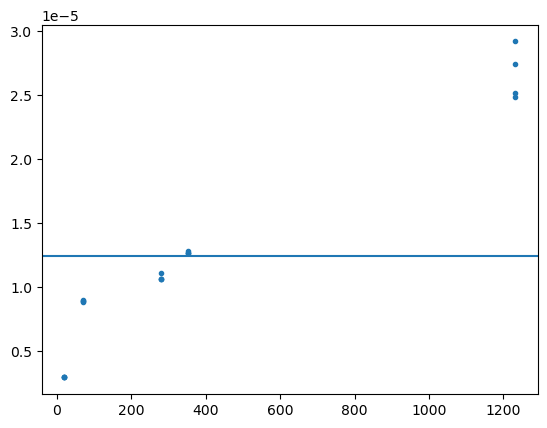

In [7]:
df_tmp = df_info[df_info["model"].astype(str).str.contains("marbl", case=False, na=False)]
print(f"P = {df_tmp.performance_number.mean():0.3e} ± {df_tmp.performance_number.std():0.3e}")

plt.plot(df_tmp.ntasks, df_tmp.performance_number, '.')
plt.axhline(df_tmp.performance_number.mean())

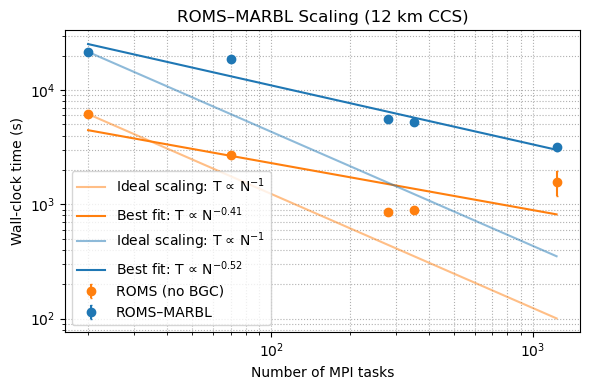

In [8]:
plt.figure(figsize=(6, 4))

summary = (
    df_info[df_info["model"].astype(str).str.contains("no-bgc", case=False, na=False)]
    .groupby("ntasks", as_index=False)
    .agg(
        mean_time=("elapsed_time", "mean"),
        std_time=("elapsed_time", "std"),
        n_runs=("elapsed_time", "count"),
    )
    .sort_values("ntasks")
)
ntasks = summary.ntasks.to_numpy()
time_mean = summary.mean_time.to_numpy()
time_std = summary.std_time.to_numpy()

plt.errorbar(
    ntasks,
    time_mean,
    yerr=time_std,
    fmt='o',
    color="tab:orange",    
    capsize=1,
    label="ROMS (no BGC)"
)

# Ideal strong-scaling line (relative to smallest ntasks)
ntasks = summary.ntasks.to_numpy()
t = summary.mean_time.to_numpy()
ideal = t[0] * ntasks[0] / ntasks

plt.plot(ntasks, ideal, linestyle='-', color="tab:orange", alpha=0.5, label="Ideal scaling: T ∝ N$^{-1}$")

# ---- Best-fit power-law line ----
logN = np.log10(ntasks)
logT = np.log10(time_mean)

slope, intercept = np.polyfit(logN, logT, 1)
fit_time = 10 ** (intercept + slope * logN)

plt.plot(
    ntasks,
    fit_time,
    linestyle='-',
    color='tab:orange',
    label=f"Best fit: T ∝ N$^{{{slope:.2f}}}$"
)

#---------------------------------------------
# marble
summary = (
    df_info[df_info["model"].astype(str).str.contains("marbl", case=False, na=False)]
    .groupby("ntasks", as_index=False)
    .agg(
        mean_time=("elapsed_time", "mean"),
        std_time=("elapsed_time", "std"),
        n_runs=("elapsed_time", "count"),
    )
    .sort_values("ntasks")
)
ntasks = summary.ntasks.to_numpy()
time_mean = summary.mean_time.to_numpy()
time_std = summary.std_time.to_numpy()

plt.errorbar(
    ntasks,
    time_mean,
    yerr=time_std,
    fmt='o',
    color="tab:blue",
    capsize=1,
    label="ROMS–MARBL"
)


# Ideal strong-scaling line (relative to smallest ntasks)
ntasks = summary.ntasks.to_numpy()
t = summary.mean_time.to_numpy()
ideal = t[0] * ntasks[0] / ntasks

plt.plot(ntasks, ideal, linestyle='-', color="tab:blue", alpha=0.5, label="Ideal scaling: T ∝ N$^{-1}$")

# ---- Best-fit power-law line ----
logN = np.log10(ntasks)
logT = np.log10(time_mean)

slope, intercept = np.polyfit(logN, logT, 1)
fit_time = 10 ** (intercept + slope * logN)

plt.plot(
    ntasks,
    fit_time,
    linestyle='-',
    color='tab:blue',
    label=f"Best fit: T ∝ N$^{{{slope:.2f}}}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of MPI tasks")
plt.ylabel("Wall-clock time (s)")
plt.title("ROMS–MARBL Scaling (12 km CCS)")
plt.legend()
plt.grid(True, which="both", linestyle=":")

plt.tight_layout()
plt.show()

Old data from Pierre:

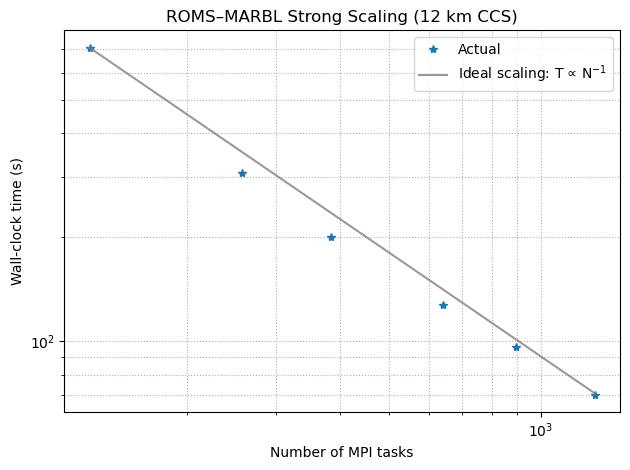

In [9]:
ntasks = np.array([128, 256, 384, 640, 896, 1280])
time_mean = np.array([707.9, 307.7, 201.0, 127.2, 96.1, 70.1])

plt.plot(ntasks, time_mean, "*", color="tab:blue", label="Actual")
ideal = time_mean[0] * ntasks[0] / ntasks

plt.plot(ntasks, ideal, linestyle='-', color="gray", alpha=0.8, label="Ideal scaling: T ∝ N$^{-1}$")


plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of MPI tasks")
plt.ylabel("Wall-clock time (s)")
plt.title("ROMS–MARBL Strong Scaling (12 km CCS)")
plt.legend()
plt.grid(True, which="both", linestyle=":")

plt.tight_layout()
plt.show()